# Systems Kinematics:

Members: Viraj Kanchan, Nathan Mayer, Shubang Mukund, Matthew Nolan

Code Draft Written by Nathan Mayer

Code Adapted from the Triple Pendulum Example and Solving Nonlinear Four-Bar Constraints Code Written by Professor Daniel Aukes

Triple Pendulum Example Code: https://foldable-robotics.github.io/modules/dynamics/generated/08-triple-pendulum-example/

##System Kinematics Figure:

<img src='https://drive.google.com/uc?id=1n8KlDhqv8kxqkUDIxMgCXLMRzwZ3RAF0' width="600">

##Paper Model:

<img src='https://drive.google.com/uc?id=1UjM9wa0ghvNNOO5JXU1Iy3jgVrLcS6f2' width="300">

<img src='https://drive.google.com/uc?id=1uYPlwpIFRbJQvaMWyjlJh5Tn5gu700NQ' width="300">

<img src='https://drive.google.com/uc?id=1t2fsh0MN521ZPTDzsgL6mwciavRxpNaM' width="300">



##Pynamics Script:

In [1]:
use_constraints = False

In [2]:
# Import all necessary packages:

#pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [3]:
# Define Initial System:

system = System()
pynamics.set_system(__name__,system)

### Parametrization:

In [4]:
# Create constant values for length, mass, springs, inertia, etc.

lA1 = Constant(1/20,'lA1',system)
lB1 = Constant(0.75/20,'lB1',system)
lC1 = Constant(1/20,'lC1',system)
lA2 = Constant(0.75/20,'lA2',system)
lB2 = Constant(0.5/20,'lB2',system)
lA3 = Constant(1.75/20,'lA3',system)

mA1 = Constant(0.25/2,'mA1',system)
mB1 = Constant(0.25/2,'mB1',system)
mC1 = Constant(0.25/2,'mC1',system)
mA2 = Constant(0.25/2,'mA2',system)
mB2 = Constant(0,'mB2',system)
mA3 = Constant(0.25/2,'mA3',system)

m_body = Constant(5/2,'m_body',system)

m_tot = (mA1 + mB1 + mC1 + mA2 + mB2 + mA3) * 4 + m_body

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)

Ixx_A1 = Constant(1,'Ixx_A1',system)
Iyy_A1 = Constant(1,'Iyy_A1',system)
Izz_A1 = Constant(1,'Izz_A1',system)
Ixx_B1 = Constant(1,'Ixx_B1',system)
Iyy_B1 = Constant(1,'Iyy_B1',system)
Izz_B1 = Constant(1,'Izz_B1',system)
Ixx_C1 = Constant(1,'Ixx_C1',system)
Iyy_C1 = Constant(1,'Iyy_C1',system)
Izz_C1 = Constant(1,'Izz_C1',system)
Ixx_A2 = Constant(1,'Ixx_A2',system)
Iyy_A2 = Constant(1,'Iyy_A2',system)
Izz_A2 = Constant(1,'Izz_A2',system)
Ixx_B2 = Constant(1,'Ixx_B2',system)
Iyy_B2 = Constant(1,'Iyy_B2',system)
Izz_B2 = Constant(1,'Izz_B2',system)
Ixx_A3 = Constant(1,'Ixx_A3',system)
Iyy_A3 = Constant(1,'Iyy_A3',system)
Izz_A3 = Constant(1,'Izz_A3',system)

torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)

In [5]:
# Differentiable State Variables:

qA1,qA1_d,qA1_dd = Differentiable('qA1',system)
qB1,qB1_d,qB1_dd = Differentiable('qB1',system)
qC1,qC1_d,qC1_dd = Differentiable('qC1',system)
qA2,qA2_d,qA2_dd = Differentiable('qA2',system)
qB2,qB2_d,qB2_dd = Differentiable('qB2',system)

In [6]:
# Initial Values:

initialvalues = {}
initialvalues[qA1]=(0)*pi/180
initialvalues[qA1_d]=0*pi/180
initialvalues[qB1]=(-110)*pi/180
initialvalues[qB1_d]=0*pi/180
initialvalues[qC1]=(-40)*pi/180
initialvalues[qC1_d]=0*pi/180
initialvalues[qA2]=(-130)*pi/180
initialvalues[qA2_d]=0*pi/180
initialvalues[qB2]=(50)*pi/180
initialvalues[qB2_d]=0*pi/180

In [7]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

### Kinematics:

In [8]:
# Define All Frames:

N = Frame('N',system)
A1 = Frame('A1',system)
B1 = Frame('B1',system)
C1 = Frame('C1',system)
A2 = Frame('A2',system)
B2 = Frame('B2',system)
A3 = Frame('A3',system)

In [9]:
# Define Newtonian Frame:

system.set_newtonian(N)

In [10]:
# Define Frame Rotations:

A1.rotate_fixed_axis(N,[0,0,1],qA1,system)
B1.rotate_fixed_axis(A1,[0,0,1],qB1,system)
C1.rotate_fixed_axis(B1,[0,0,1],qC1,system)
A2.rotate_fixed_axis(N,[0,0,1],qA2,system)
B2.rotate_fixed_axis(A2,[0,0,1],qB2,system)
A3.rotate_fixed_axis(A2,[0,0,1],qB2,system)

In [11]:
# Create Point Vectors based on Frame Rotations:

pNA1 = 0*N.x
pA1B1 = pNA1 + lA1*A1.x
pB1C1 = pA1B1 + lB1*B1.x
pC1B2 = pB1C1 + lC1*C1.x

pNA2 = 0*N.x
pA2B2 = pNA2 + lA2*A2.x
pB2C1 = pA2B2 + lB2*B2.x

pA2A3 = pA2B2 + lA3*B2.x

In [12]:
# Create an array of points:

points = [pC1B2,pB1C1,pA1B1,pNA1,pNA2,pA2B2,pB2C1,pA2A3]

p = numpy.array(points)

In [13]:
# Plot Estimated System Position:

l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(N.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(N.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(N.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[-0.00612702556393450, 0.0371742446252874, 0.0500000000000000, 0, 0, -0.0241045353632452, -0.0197633309215720, -0.00891031981738882]
py1: 
[-0.0602384732794716, -0.0352384732794716, 0, 0, 0, -0.0287266666169617, -0.0533468604422669, -0.114897345005530]
pz1: 
[0, 0, 0, 0, 0, 0, 0, 0]


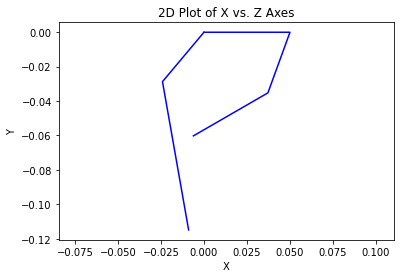

In [14]:
# 2D Plot (X vs. Z Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Z Axes');

### Solve for valid initial condition determined by independent variable:

In [15]:
# Setup Optimization Equations:

ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pB2C1-pC1B2] # Output Should be Zero when End Points from Each Segment are Subtracted

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))

eq_scalar

[-lA1*cos(qA1) + lA2*cos(qA2) + lB1*sin(qA1)*sin(qB1) - lB1*cos(qA1)*cos(qB1) - lB2*sin(qA2)*sin(qB2) + lB2*cos(qA2)*cos(qB2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*cos(qC1) - lC1*(-sin(qA1)*cos(qB1) - sin(qB1)*cos(qA1))*sin(qC1), -lA1*sin(qA1) + lA2*sin(qA2) - lB1*sin(qA1)*cos(qB1) - lB1*sin(qB1)*cos(qA1) + lB2*sin(qA2)*cos(qB2) + lB2*sin(qB2)*cos(qA2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*sin(qC1) - lC1*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1)]

In [16]:
# Define Independent and Dependent Variables

qi = [qA1,qA2,qB1]
qd = [qC1,qB2]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()


In [17]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [18]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

In [19]:
# Save New Points to Plot the Actual System Results:

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

In [20]:
# Display Error from Optimization Equation:
result.fun

5.304033604483377e-09

2022-02-25 16:05:51,857 - pynamics.output - INFO - calculating outputs
2022-02-25 16:05:51,865 - pynamics.output - INFO - done calculating outputs


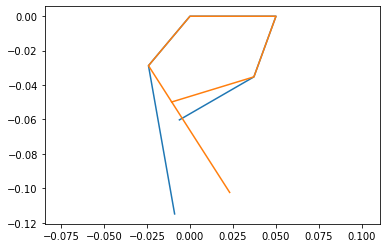

In [21]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points.plot_time()

In [22]:
# Define a new State for Joint Angles based on Optimization Equation:

state2 = {}
state2[qA1] = initialvalues[qA1]
state2[qA1_d]= 0*pi/180
state2[qB1]= initialvalues[qB1]
state2[qB1_d] = 0*pi/180
state2[qC1] = result.x[0]
state2[qC1_d] = 0*pi/180
state2[qA2] = initialvalues[qA2]
state2[qA2_d] = 0*pi/180
state2[qB2] = result.x[1]
state2[qB2_d] = 0*pi/180

### Calculating Jacobian:

In [23]:
# Take Derivative of Optimization Equation:

eq_d=[(system.derivative(item)) for item in eq_scalar]
eq_d = sympy.Matrix(eq_d)
eq_d = eq_d.subs(system.constant_values)
eq_d

Matrix([
[qA1_d*(0.05*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*sin(qC1) + 0.05*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1) + 0.0375*sin(qA1)*cos(qB1) + 0.05*sin(qA1) + 0.0375*sin(qB1)*cos(qA1)) + qA2_d*(-0.025*sin(qA2)*cos(qB2) - 0.0375*sin(qA2) - 0.025*sin(qB2)*cos(qA2)) + qB1_d*(0.05*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*sin(qC1) + 0.05*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1) + 0.0375*sin(qA1)*cos(qB1) + 0.0375*sin(qB1)*cos(qA1)) + qB2_d*(-0.025*sin(qA2)*cos(qB2) - 0.025*sin(qB2)*cos(qA2)) + qC1_d*(-0.05*(sin(qA1)*sin(qB1) - cos(qA1)*cos(qB1))*sin(qC1) + 0.05*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1))],
[  qA1_d*(0.05*(sin(qA1)*sin(qB1) - cos(qA1)*cos(qB1))*cos(qC1) + 0.05*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*sin(qC1) + 0.0375*sin(qA1)*sin(qB1) - 0.0375*cos(qA1)*cos(qB1) - 0.05*cos(qA1)) + qA2_d*(-0.025*sin(qA2)*sin(qB2) + 0.025*cos(qA2)*cos(qB2) + 0.0375*cos(qA2)) + qB1_d*(0.05*(sin(qA1)*sin(qB1) - cos(qA1)*cos(qB1))*cos(qC1) + 0.05*(sin(qA1)*cos(qB1) + si

In [24]:
# Define Independent and Dependent Variables:

qi = sympy.Matrix([qA1_d,qA2_d,qB1_d])

qd = sympy.Matrix([qC1_d,qB2_d])

In [25]:
# Take Partial Derivative with Respect to Independent Variables:

AA = eq_d.jacobian(qi)

# Take Partial Derivative with Respect to Dependent Variables:

BB = eq_d.jacobian(qd)

J_int= -BB.inv()*AA
J_int.simplify()

In [26]:
# Define End Effector Position:

pout = 0*N.x + lA1*A1.x + lB2*B2.x + lA3*B2.x

# Take Time Derivative for End Effector Velocity:

vout = pout.time_derivative()
vout = sympy.Matrix([vout.dot(N.x),vout.dot(N.y)])
vout

Matrix([
[-lA1*qA1_d*sin(qA1) - (lA3 + lB2)*(qA2_d + qB2_d)*sin(qA2)*cos(qB2) - (lA3 + lB2)*(qA2_d + qB2_d)*sin(qB2)*cos(qA2)],
[ lA1*qA1_d*cos(qA1) - (lA3 + lB2)*(qA2_d + qB2_d)*sin(qA2)*sin(qB2) + (lA3 + lB2)*(qA2_d + qB2_d)*cos(qA2)*cos(qB2)]])

In [27]:
# Calculate Jacobian from End Effector Velocity from Independent and Dependent Variables:

Ji = vout.jacobian(qi)
Jd = vout.jacobian(qd)

# Caculate Total Jacobian:

J = Ji+Jd*J_int
J.simplify()
J

Matrix([
[-(lA1*sin(qA1)*sin(qA1 - qA2 + qB1 - qB2 + qC1) + 1.0*(lA3 + lB2)*(1.5*sin(qC1) + 2.0*sin(qB1 + qC1))*sin(qA2 + qB2))/sin(qA1 - qA2 + qB1 - qB2 + qC1), (lA3 + lB2)*(-sin(qA2 + qB2)*sin(qA1 - qA2 + qB1 - qB2 + qC1) - 0.5*cos(qA1 + qB1 + qC1) - 0.75*cos(qA1 + qB1 + qB2 + qC1) + 0.5*cos(qA1 - 2*qA2 + qB1 - 2*qB2 + qC1) + 0.75*cos(qA1 - 2*qA2 + qB1 - qB2 + qC1))/sin(qA1 - qA2 + qB1 - qB2 + qC1), -1.5*(lA3 + lB2)*sin(qC1)*sin(qA2 + qB2)/sin(qA1 - qA2 + qB1 - qB2 + qC1)],
[ (lA1*sin(qA1 - qA2 + qB1 - qB2 + qC1)*cos(qA1) + 1.0*(lA3 + lB2)*(1.5*sin(qC1) + 2.0*sin(qB1 + qC1))*cos(qA2 + qB2))/sin(qA1 - qA2 + qB1 - qB2 + qC1), (lA3 + lB2)*(-0.5*sin(qA1 + qB1 + qC1) - 0.75*sin(qA1 + qB1 + qB2 + qC1) - 0.5*sin(qA1 - 2*qA2 + qB1 - 2*qB2 + qC1) - 0.75*sin(qA1 - 2*qA2 + qB1 - qB2 + qC1) + sin(qA1 - qA2 + qB1 - qB2 + qC1)*cos(qA2 + qB2))/sin(qA1 - qA2 + qB1 - qB2 + qC1),  1.5*(lA3 + lB2)*sin(qC1)*cos(qA2 + qB2)/sin(qA1 - qA2 + qB1 - qB2 + qC1)]])

In [28]:
# Subsitute State Values from Optimization Equation into Jacobian:

J2 = J.subs(system.constant_values)
J2 = J2.subs(state2)
print('J2: ')
print(J2)

J2: 
Matrix([[0.175363246497361, -0.0803987555387230, 0.117874249234321], [0.162325666764691, -0.0514979278914890, 0.0755021585428498]])


### Joint Velocities: (From Jacobian)

In [29]:
# Calculate Joint Velocities from Sample Velocities from Biomimicry Research and Jacobian Transpose:

v = sympy.Matrix([[10],[1]])

q_d = J2.T*v
print('q_d: ')
print(q_d)

q_d: 
Matrix([[1.91595813173830], [-0.855485483278719], [1.25424465088606]])


### Forces and Torques: (Using Jacobian)

In [30]:
# Define End Effector Force as Percentage of Total Mass:

f = sympy.Matrix([[0.10*m_tot*g],[0.43*m_tot*g]])
f = f.subs(system.constant_values)
print('f: ')
print(f)

# Calculate Joint Torques Based on End Effector Forces:

T = J2.T*f
print('T: ')
print(T)

f: 
Matrix([[4.90500000000000], [21.0915000000000]])
T: 
Matrix([[4.28384852463704], [-1.48052444204078], [2.17062696940086]])


## Discussion:

**1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?**

>Because the device is essentially a planar five-bar linkage with one link extended, it has two degrees of freedom. It also has two motors, which drive the upper two angles of the device. (i.e. the angle between $N$ and $A_1$, and that between $N$ and $A_2$). Because there are as many motors as there are degrees of freedom, the system is fully constrained by the two input angles.

**2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work together to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?**

>The two degrees of freedom will work together to define the output position of the end effector (in this case, the foot). In order to create a locomotory gait, the desired output motion of the foot will be analyzed, and the necessary joint position inputs will be calculated as a function of time using the system kinematics and dynammics. This will allow the cyclic joint positions to be sent to each motor as a function of time. Each of the four legs of the quadruped will perform the exact same output motions, with some phase difference between them. The exact phase shift pattern and the speed at which the cycle is run will determine the gait of the robot. 

**3. How did you estimate your expected end-effector forces?**

The end effector forces were estimated according to the paper [1].
The peak force exerted by an average small dog (weight<10kgs) is around 43% on the front limb and 27% on the rear limb. See the table below.

<img src='https://drive.google.com/uc?id=1nBArtuZ-QmYBnSvtZQbsbdKjHUMEGxn3' width="1000">

A weight of 10kgs was assumed to be a starting point weight. Thus the max weight to be pushed per leg would be 4.3kgs. The team doesn’t intend to build a foldable robot weighing 10kgs, but assuming a higher value in terms of torque would be beneficial for two reasons; the intended design would be able to maneuver difficult terrain if it ever were to get stuck and secondly the higher peak torque capability of the motor would help with achieving higher efficiency as the motor would be operating in its rated range and consuming lesser power.



**4. How did you estimate your expected end-effector speeds?**

The speed of the foot of a dog is quite a well-researched subject and we have sourced the value from the research paper [1]. See the table below for reference.

<img src='https://drive.google.com/uc?id=1nCiBKrqTmCt7YyfuRJ-Y68VajXIG3gUS' width="1000">

As can be seen from the above table the LV (limb velocity) value for small dogs is 0.72-0.73m/s for small dogs. Since we have sourced our inspiration from the gait of small dogs specifically. We have assumed the speed as 0.8m/s.


## Bibliography:

[1] J. Kim, K. A. Kazmierczak, and G. J. Breur, “Comparison of temporospatial and kinetic variables of walking in small and large dogs on a pressure-sensing walkway,” *American Journal of Veterinary Research*, vol. 72, no. 9, pp. 1171–1177, 2011. 